In [195]:
!if [ ! -d mov-in-covid ]; then \
  git clone https://github.com/tanaxer01/mov-in-covid; \
  mv mov-in-covid/*.py .; fi

from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy  as np
import utils

In [196]:
datasets = {
  # DP51
  "dp51_difs": "https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto51/ISCI_std.csv",
  # DP82
  "dp82_weeks": "https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto82/ISCI_weeks.csv",
  "dp82_weekends": "https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto82/ISCI_weekends.csv",
  # DP...
}

for name, url in datasets.items():
  utils.get_file(name, url)

# DATASET PREP

## DP51
link: [product51](https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto51)


In [258]:
df_difs = pd.read_csv("./datos/dp51_difs.csv")

# Fecha to Datetime && sort by Fecha
df_difs['Fecha'] = pd.to_datetime(df_difs['Fecha'])
df_difs = df_difs.sort_values(by=['Fecha'])

# Just RM
df_difs = df_difs[ df_difs['Codigo region'] == 13 ].drop(columns=['Region', 'Codigo region'])

# Calc prom of Dif salida y Dif entrada.
def parse_diff(x):
  mean = sum([ int(i)  for i in x[1:-2].replace('%','').split(",") ])/2
  
  return (100 + mean)/100

df_difs['Salida'] = df_difs['Dif salida'].map(parse_diff)
df_difs['Entrada'] = df_difs['Dif entrada'].map(parse_diff)

df_salidas  = pd.DataFrame({ i:df_difs[ df_difs["Comuna"] == i ].groupby("Fecha")["Salida"].mean() for i in set(df_difs["Comuna"]) })
df_entradas = pd.DataFrame({ i:df_difs[ df_difs["Comuna"] == i ].groupby("Fecha")["Entrada"].mean() for i in set(df_difs["Comuna"]) })

df_difs.head(1)

,Comuna,Codigo comuna,Cartodb id,Zona censal,Week,Dif salida,Dif entrada,Fecha,Salida,Entrada
458790,Peñalolén,13122,501401,13122011003,9,"[-21%,+20%,]","[-21%,+20%,]",2020-03-02,0.995,0.995


## DP82
link: [product82](https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto82)

In [257]:
df_weeks = pd.read_csv('./datos/dp82_weeks.csv')
#df_weekends = pd.read_csv('./datos/dp82_weekends.csv')

# Fecha to Datetime && sort by Fecha
df_weeks['fecha_inicio'] = pd.to_datetime(df_weeks['fecha_inicio'])
df_weeks = df_weeks.sort_values(by=['fecha_inicio'])

# Just RM
df_weeks = df_weeks[ df_weeks['region'] == 13 ].drop(columns=['region'])

# Just dates on DP51
df_weeks = df_weeks[ df_weeks["fecha_inicio"].isin(df_difs["Fecha"]) ]

# [!] Fill pasos 
df_weeks["paso"] = df_weeks["paso"].fillna(method="ffill")

# DF pasos
df_pasos = df_weeks.pivot_table(values='paso', index='fecha_inicio', columns='nom_comuna')

df_weeks.head(1)

,semana,paso,nom_comuna,comuna,fecha_inicio,fecha_termino,var_salidas,var_salidas_cota_inferior,var_salidas_cota_superior
11544,9,0.0,PUDAHUEL,13124,2020-03-02,2020-03-06,0.988342,0.985605,0.99108


## `Dif salida` VS `var_salidas`
En general siguen las mismas tendencias, pero tienen una diferencia de 0.2 que no estoy seguro pq ocurre.
Lo unico raro es la diferencia al final, (el peak hacia abajo es por un error de mediciones en uno de los datasets.) pero al final, el dataset `var` tiene un amuento raro que no se ve en la otra curva.

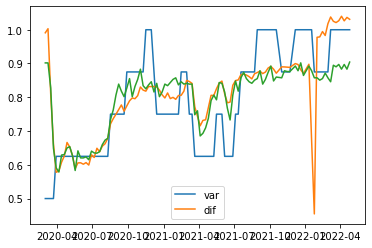

'shift promedio entre var y dif: 0.19000725738526164'

In [217]:
dif  = df_salidas["Santiago"]
var  = df_weeks[ df_weeks["nom_comuna"] == "SANTIAGO" ].set_index("fecha_inicio")

var_salidas = var["var_salidas"]
paso = var["paso"]

plt.figure()

plt.plot(paso / 8 + 0.5)
plt.plot(var_salidas)
plt.plot(dif - 0.2)

plt.legend(["var", "dif"])
plt.show()

f"shift promedio entre var y dif: {(dif - var_salidas).mean()}"

# Medición de eficiencia